# 1.SMO算法

In [1]:
import numpy as np
import pandas as pd

In [2]:
"""
函数功能：创建特征向量和标签向量
参数说明：
        file:原始文件路径
返回：
        xMat:特征向量
        yMat:标签向量
"""
def loadDataSet(file):
    dataSet = pd.read_table(file, header = None)
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat, yMat

In [3]:
#导入数据集
file = 'testSet.txt'
xMat , yMat = loadDataSet(file)

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def showDataSet(xMat, yMat):
    data_p = []           #正样本
    data_n = []           #负样本
    m = xMat.shape[0]     #样本总数
    for i in range(m):
        if yMat[i] > 0:
            data_p.append(xMat[i])
        else:
            data_n.append(xMat[i])
    data_p_ = np.array(data_p)                #转化为numpy矩阵
    data_n_ = np.array(data_n)                #转化为numpy矩阵
    plt.scatter(data_p_.T[0], data_p_.T[1])   #正样本散点图
    plt.scatter(data_n_.T[0], data_n_.T[1])   #负样本散点图
    plt.show()

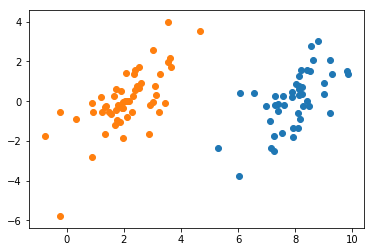

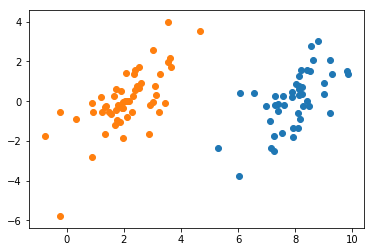

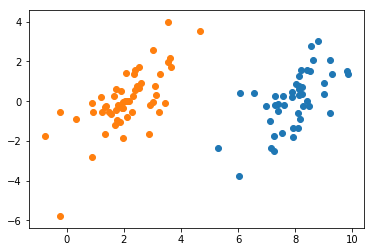

In [5]:
showDataSet(xMat, yMat)

In [6]:
import random

In [7]:
"""
函数功能：随机选择一个索引
参数说明：
        i：第一个alpha索引
        m：数据集总行数
返回：
        j：随机选择的不与i相等的值
"""
def selectJrand(i,m):
    j = i
    while(j == i):
        j = int(random.uniform(0,m))
    return j

αj的修剪函数

In [8]:
"""
函数功能：修剪alpha_j
"""
def clipAlpha(aj,H,L):
    if aj > H:
        aj = H
    if L > aj:
        aj = L
    return aj

2. 简化版SMO算法

In [9]:
"""
函数功能：
参数说明：
        xMat:特征向量
        yMat:标签向量
        C： 常数
        toler: 容错率
        maxIter :最大迭代次数
返回：
        b、alpha
"""
def smoSimple(xMat, yMat,C,toler,maxIter):
    b = 0                #初始化b参数
    m,n = xMat.shape      #m为数据集的总行数，n为特征的数量
    alpha = np.mat(np.zeros((m,1)))      #初始化alpha参数，设为0
    iters = 0                            #初始化迭代次数
    while(iters < maxIter):
        alpha_ = 0                       #初始化alpha优化次数
        for i in range(m):
            #步骤1：计算误差Ei
            fXi = np.multiply(alpha,yMat).T * (xMat * xMat[i,:].T) + b
            Ei = fXi - yMat[i]
            #优化alpha，设定容错率
            if((yMat[i] * Ei < -toler)and(alpha[i] < C)) or ((yMat[i] * Ei > toler)and(alpha[i]>0)):
                #随机选择一个于alpha_i成对优化的alpha_j
                j = selectJrand(i,m)
              #步骤1：计算误差Ej
                fXj = np.multiply(alpha,yMat).T * (xMat * xMat[j,:].T)+b
                Ej = fXj - yMat[j]
                #保存更新前的alpha_j和alpha_j
                alphaIold = alpha[i].copy()
                alphaJold = alpha[j].copy()
                #步骤2：计算上下界H和L
                if (yMat[i]!=yMat[j]):
                    L = max(0,alpha[j] - alpha[i])
                    H = min(C,C+alpha[j] - alpha[i])
                else:
                    L = max(0,alpha[j] + alpha[i] - C)
                    H = min(C,C+alpha[j] + alpha[i])
                if L==H:
                    continue
                #步骤3：计算学习率eta(eta是alpha_j的最优修改量)
                eta = 2 * xMat[i,:] * xMat[j,:].T - xMat[i,:]* xMat[i,:].T - xMat[j,:] * xMat[j,:].T
                if eta >= 0:
                    continue
                #步骤4：更新alpha_j
                alpha[j] -= yMat[j] * (Ei - Ej)/eta
                #步骤5：修剪alpha_j
                alpha[j] = clipAlpha(alpha[j],H,L)
                if abs(alpha[j] - alphaJold) < 0.00001:
                    continue
                #步骤6：更新alpha_i
                alpha[i] += yMat[j] * yMat[i] * (alphaJold - alpha[j])
                #步骤7：更新b_1和b_2
                b1 = b - Ei - yMat[i] * (alpha[i] - alphaIold) * xMat[i,:] * xMat[i,:].T - yMat[j] * (alpha[j]-alphaJold) * xMat[i,:] * xMat[j,:].T
                b2 = b - Ej - yMat[i] * (alpha[i] - alphaIold) * xMat[i,:] * xMat[j,:].T - yMat[j] * (alpha[j]-alphaJold) * xMat[j,:] * xMat[j,:].T
                #步骤8：根据b_1和b_2更新b
                if(0<alpha[i])and(C>alpha[i]):
                    b = b1
                elif (0<alpha[j])and(C>alpha[j]):
                    b = b2
                else:
                    b = (b1+b2)/2
                #优化统级次数
                alpha_ +=1
        #更新迭代次数
        if alpha_ == 0:
            iters += 1
        else:
            iters = 0
    return b,alpha

In [10]:
%time b,alpha = smoSimple(xMat, yMat,0.6,0.001,5)

Wall time: 51.7 s
Wall time: 51.7 s
Wall time: 51.7 s


In [11]:
b

matrix([[-8.27540732]])

matrix([[-8.27540732]])

matrix([[-8.27540732]])

支持向量的可视化

In [12]:
"""
函数功能：提取出支持向量，用于后面画图
"""
def get_sv(xMat, yMat,alpha):
    m = xMat.shape[0]
    sv_x = []
    sv_y = []
    for i in range(m):
        if alpha[i] > 0:
            sv_x.append(xMat[i])
            sv_y.append(yMat[i])
    sv_x1 = np.array(sv_x).T
    sv_y1 = np.array(sv_y).T
    return sv_x1, sv_y1

In [13]:
sv_x1, sv_y1 = get_sv(xMat, yMat, alpha)

In [14]:
sv_x1

array([[[ 3.634009,  3.223038,  3.457096,  5.286862,  6.080573]],

       [[ 1.730537, -0.552392, -0.082216, -2.358286,  0.418886]]])

array([[[ 3.634009,  3.223038,  3.457096,  5.286862,  6.080573]],

       [[ 1.730537, -0.552392, -0.082216, -2.358286,  0.418886]]])

array([[[ 3.634009,  3.223038,  3.457096,  5.286862,  6.080573]],

       [[ 1.730537, -0.552392, -0.082216, -2.358286,  0.418886]]])

In [15]:
sv_y1

array([[[-1, -1, -1,  1,  1]]], dtype=int64)

array([[[-1, -1, -1,  1,  1]]], dtype=int64)

array([[[-1, -1, -1,  1,  1]]], dtype=int64)

In [16]:
def showPlot(xMat,yMat,alpha,b):
    data_p = []    #正样本
    data_n = []    #负样本
    m = xMat.shape[0]     #样本总数
    for i  in range(m):
        if yMat[i] > 0:
            data_p.append(xMat[i])
        else:
            data_n.append(xMat[i])
    data_p_ = np.array(data_p)   #转换为numpy矩阵
    data_n_ = np.array(data_n)
    #样本散点图
    plt.scatter(data_p_.T[0], data_p_.T[1])   #正样本散点图
    plt.scatter(data_n_.T[0], data_n_.T[1])   #负样本散点图
    #绘制支持向量机
    sv_x, sv_y = get_sv(xMat, yMat, alpha)
    plt.scatter(sv_x[0], sv_x[1],s = 150, c = 'none', alpha = 0.7, linewidth = 1.5, edgecolor = 'red')
    #绘制超平面
    w = np.dot((np.tile(np.array(yMat).reshape(1,-1).T,(1,2))*np.array(xMat)).T, np.array(alpha))
    a1, a2 = w
    x1 = max(xMat[:,0])[0,0]
    x2 = min(xMat[:,0])[0,0]
    b = float(b)
    a1 = float(a1[0])
    a2 = float(a2[0])
    y1, y2 = (-b - a1 * x1 )/a2,(-b - a1 * x2)/a2
    plt.plot([x1,x2], [y1, y2])
    plt.show()

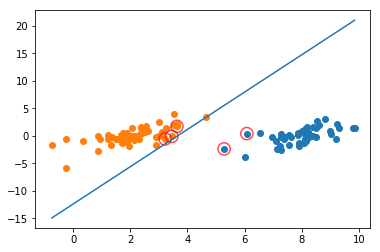

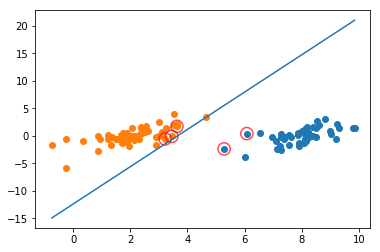

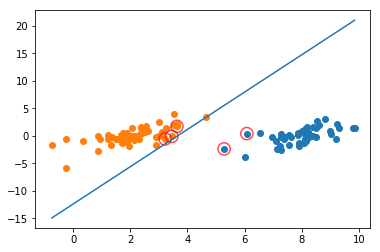

In [17]:
showPlot(xMat,yMat,alpha,b)

3. 完整版SMO算法

构建辅助函数

In [18]:
"""
数据结构：维护所有需要操作的值
参数说明：
        xMat: 特征矩阵
        yMat: 标签矩阵
        C：松弛变量
        toler: 容错率
"""
class optStruct:
    def __init__(self, xMat,yMat,C,toler):
        self.X = xMat             #特征矩阵
        self.Y = yMat             #数据标签
        self.C = C               #松弛变量
        self.tol = toler          #容错率
        self.m = xMat.shape[0]    #特征矩阵行数
        self.alpha = np.mat(np.zeros((self.m,1)))    #根据矩阵行数初始化alpha参数为0
        self.b = 0                       #初始化b参数为0
        self.eCa = np.mat(np.zeros((self.m,2)))    #根据矩阵行数初始化误差缓存，第一列为是否有效的标志位，第二列为实际误差E的值
        

In [19]:
"""
函数功能：计算误差
参数说明：
        oS: 数据结构
        k：标号为k的数据
返回：
        Ek:标号为k的数据误差
"""
def calcEk(oS, k):
    fXk = np.multiply(oS.alpha, oS.Y).T * (oS.X * oS.X[k,:].T) + oS.b
    Ek = fXk - oS.Y[k]
    return Ek

In [20]:
"""
内循环启发方式
参数说明：
        i:标号为i的数据的索引值
        oS:数据结构
        Ei：标号为i的数据误差
返回：
    j，maxK:标号为j或maxK的数据的索引值
    Ej：标号为j的数据误差
"""
def selectJ(i, oS, Ei):
    maxK = -1; maxDeltaE = 0; Ej = 0      #初始化
    oS.eCa[i] = [1,Ei]                    #根据Ei更新误差缓存
    eCa = np.nonzero(oS.eCa[:, 0].A)[0]   #返回误差不为0的数据的索引值
    if (len(eCa)) > 1:                    #有不为0的误差
        for k in eCa:                     #遍历，找到最大的Ek
            if k == i: 
                continue                  #不计算i
            Ek = calcEk(oS,k)             #计算Ek
            deltaE = abs(Ei - Ek)         #计算|Ei - Ek|
            if (deltaE > maxDeltaE):     #找到maxDeltaE
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej    #返回maxK,Ej
    else:    #没有不为0的误差
        j = selectJrand(1,oS.m)    #随机选择alpha_j的索引值
        Ej = calcEk(oS, j)        #计算Ej
    return j , Ej      

In [21]:
"""
函数功能：计算Ek，并更新误差缓存
参数说明：
        oS:数据结构
        k： 标号为k的数据的索引值
返回：无"""
def updateEk(oS,k):
    Ek = calcEk(oS, k)   #计算Ek
    oS.eCa[k] = [1,Ek]    #更新误差缓存

寻找决策边界的优化例程

In [22]:
"""
函数功能：寻找决策边界的优化例程
参数说明：
        i: 标号为i的数据的索引值
        oS：数据结构
返回：
        1：有任意一对alpha值发生变化
        0：没有任意一对alpha值发生变化或变化太小
"""
def innerL(i,oS):
    #步骤1：计算误差Ei
    Ei = calcEk(oS,i)
    #优化alpha，设定一定的容错率
    if((oS.Y[i] * Ei < -oS.tol) and (oS.alpha[i] < oS.C)) or ((oS.Y[i] * Ei > oS.tol) and (oS.alpha[i] > 0)):
        #使用内循环启发方式选择alpha_j,并计算Ej
        j,Ej = selectJ(i,oS, Ei)
        #保存更新前的alpha值，使用深拷贝
        alphaIold = oS.alpha[i].copy()
        alphaJold = oS.alpha[j].copy()
        #步骤2：计算上下界L和H
        if(oS.Y[i] != oS.Y[j]):
            L = max(0,oS.alpha[j] - oS.alpha[i])
            H = min(oS.C, oS.C + oS.alpha[j] - oS.alpha[i])
        else:
            L = max(0, oS.alpha[j] + oS.alpha[i] - oS.C)
            H = min(oS.C, oS.alpha[j] + oS.alpha[i])
        if L == H:
            return 0
        #步骤3：计算学习率eta
        eta = 2.0 * oS.X[i,:] * oS.X[j,:].T - oS.X[i,:] * oS.X[i,:].T - oS.X[j,:] * oS.X[j,:].T
        if eta >=0:
            return 0
        #步骤4：更新alpha_j
        oS.alpha[j] -= oS.Y[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alpha[j] = clipAlpha(oS.alpha[j], H, L)
        #更新Ej至误差缓存
        updateEk(oS,j)
        if (abs(oS.alpha[j] - alphaJold) < 0.00001):
            return 0
        #步骤6：更新alpha_i
        oS.alpha[i] += oS.Y[j] * oS.Y[i] * (alphaJold - oS.alpha[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei - oS.Y[i] * (oS.alpha[i] - alphaIold) * oS.X[i,:] * oS.X[i,:].T - oS.Y[j] * (oS.alpha[j] - alphaJold) * oS.X[i,:] * oS.X[j,:].T
        b2 = oS.b - Ej - oS.Y[i] * (oS.alpha[i] - alphaIold) * oS.X[i,:] * oS.X[j,:].T - oS.Y[j] * (oS.alpha[j] - alphaJold) * oS.X[j,:] * oS.X[j,:].T
        #步骤8： 根据b_1和b_2更新b
        if (0 < oS.alpha[i]) and (oS.C > oS.alpha[i]):
            oS.b = b1
        elif(0 < oS.alpha[j]) and(oS.C > oS.alpha[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2
        return 1           #如果有任意一对alpha发生改变，则返回1
    else:
        return 0           #如果没有alpha发生改变，则返回0
    

In [23]:
"""
完整的线性SMO算法
参数说明：
        xMat: 数据矩阵
        yMat: 数据标签
        C: 松弛变量
        toler: 容错率
        maxIter: 最大迭代次数
返回：
        oS.b: SMO算法计算的b
        oS.alpha:SMO算法计算的alpha
"""
def smop(xMat, yMat, C, toler, maxIter):
    oS = optStruct(xMat, yMat, C, toler)            #初始化数据结构
    iters = 0                            #初始化当前迭代次数
    entireSet = True; alpha_ = 0
    #遍历整个数据集的alpha没有更新或者超过最大迭代次数，则推出循环
    while (iters < maxIter) and ((alpha_ > 0) or (entireSet)):
        alpha_ = 0
        if entireSet:                   #遍历整个数据集
            for i in range(oS.m):
                alpha_ += innerL(i,oS)      #使用优化的SMO算法
            iters += 1
        else:                        #遍历不在边界0和C的alpha
            nonBoundIs = np.nonzero((oS.alpha.A > 0) * (oS.alpha.A < C))[0]
            for i in nonBoundIs:
                alpha_ += innerL(i,oS)
            iters += 1
        if entireSet:            #遍历一次后改为非边界遍历
            entireSet = False
        elif (alpha_ == 0):        #如果alpha没有更新，计算全样本遍历
            entireSet = True
    return oS.b,oS.alpha

In [24]:
%time b, alpha = smop(xMat, yMat,0.6,0.001,100)

Wall time: 63 ms


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


Wall time: 63 ms
Wall time: 63 ms


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In th

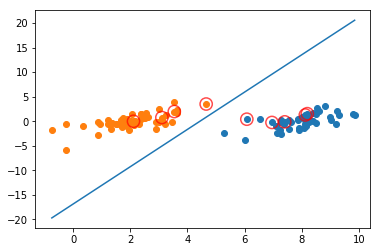

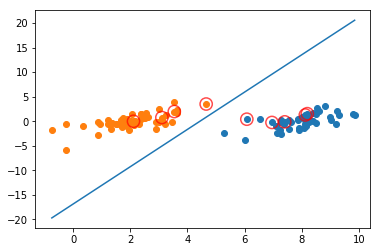

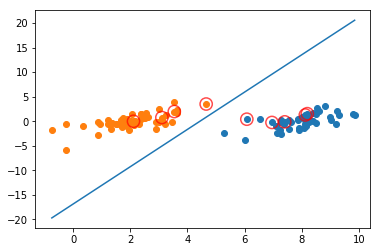

In [25]:
showPlot(xMat,yMat,alpha,b)

In [26]:
"""
函数功能：计算w
参数说明：
        xMat:特征矩阵
        yMat:标签矩阵
        alpha：alpha值
返回：
    w：计算得到的w
"""
def calcws(alpha,xMat,yMat):
    m,n = xMat.shape
    w = np.zeros((n,1))
    for i in range(m):
        w +=np.multiply(alpha[i] * yMat[i],xMat[i,:].T)   #w的计算公式
    return w

In [27]:
w = calcws(alpha, xMat,yMat)
w

array([[ 0.65307162],
       [-0.17196128]])

array([[ 0.65307162],
       [-0.17196128]])

array([[ 0.65307162],
       [-0.17196128]])

In [28]:
"""
函数功能：计算模型准确率
参数说明：
        xMat: 特征矩阵
        yMat：标签矩阵
        w：权重
        b：截距
返回：
    acc：模型预测准确度
"""
def calcAcc(xMat,yMat,w,b):
    yhat = []
    re = 0
    m,n = xMat.shape
    for i in range(m):
        result = xMat[i] * np.mat(w) + b  #超平面计算公式
        if result < 0:
            yhat.append(-1)
        else:
            yhat.append(1)
        if yhat[i] == yMat[i]:
            re += 1
    acc = re/m
    print(f'模型预测准确度为{acc}')
    return acc

In [29]:
calcAcc(xMat,yMat,w,b)

模型预测准确度为1.0


1.0

模型预测准确度为1.0


1.0

模型预测准确度为1.0


1.0

# 2.非线性SVM

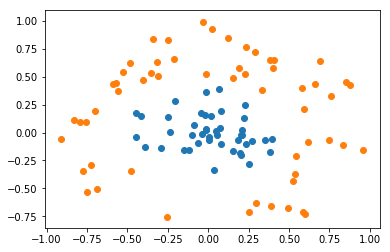

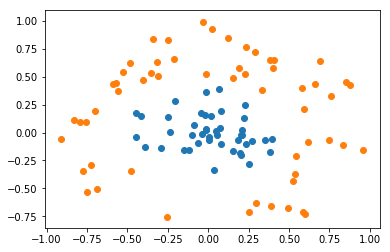

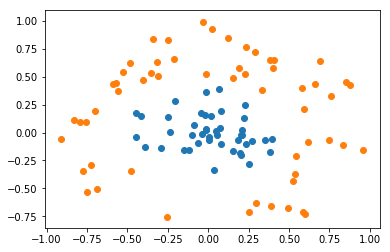

In [30]:
#导入数据集1，查看数据分布
xMat, yMat = loadDataSet('testSetRBF.txt')
showDataSet(xMat,yMat)

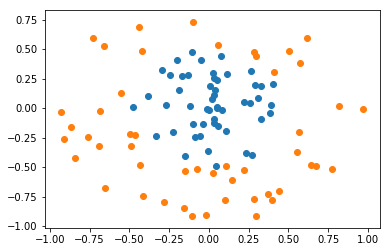

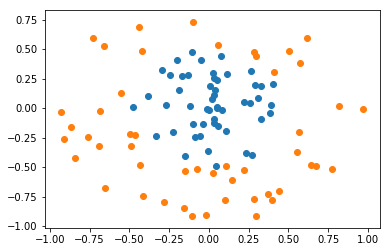

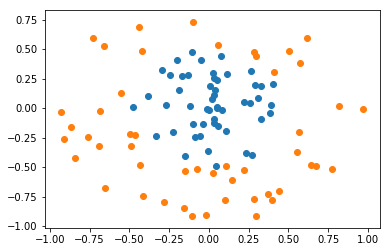

In [31]:
#导入数据集2，查看数据分布
xMat, yMat = loadDataSet('testSetRBF2.txt')
showDataSet(xMat,yMat)

1.构建核转换函数

In [32]:
"""
函数功能：通过核函数将数据转换更高维的空间（径向基函数）
参数说明：
        X：特征矩阵
        A：单个数据的向量
        kTup:包含核函数信息的元组
返回：
        K：计算的核K
"""
def kernelTrans(X,A,kTup):
    m,n = X.shape
    K = np.mat(np.zeros((m, 1)))
    if kTup[0] == 'lin':                  #如果是线性核函数
        K = X * A.T                  #线性核函数，只进行内积
    elif kTup[0] == 'rbf':           #高斯核函数，根据高斯核函数公式进行计算
        for j in range(m):
            deltaRow = X[j,:] - A
            K[j] = deltaRow * deltaRow.T
        K = np.exp(K/-1 * kTup[1] ** 2)      #计算高斯核K
    else:
        raise NameError('核函数无法识别')
    return K                             #返回计算的核K

In [33]:
"""
数据结构：维护所有需要操作的值
参数说明：
        xMat: 特征矩阵
        yMat: 标签矩阵
        C：松弛变量
        toler: 容错率
        kTup:办好核函数信息的元组，第一个参数存放核函数类别，第二个参数存放必要的核函数需要用的参数
"""
class optStruct:
    def __init__(self, xMat,yMat,C,toler,kTup):
        self.X = xMat             #特征矩阵
        self.Y = yMat             #数据标签
        self.C = C               #松弛变量
        self.tol = toler          #容错率
        self.m = xMat.shape[0]    #特征矩阵行数
        self.alpha = np.mat(np.zeros((self.m,1)))    #根据矩阵行数初始化alpha参数为0
        self.b = 0                       #初始化b参数为0
        self.eCa = np.mat(np.zeros((self.m,2)))    #根据矩阵行数初始化误差缓存，第一列为是否有效的标志位，第二列为实际误差E的值
        self.K = np.mat(np.zeros((self.m,self.m)))   #初始化核K
        for i in range(self.m):                     #计算所有数据的K
            self.K[:, i] = kernelTrans(self.X, self.X[i, :] , kTup)

In [34]:
"""
函数功能：计算误差
参数说明：
        oS: 数据结构
        k：标号为k的数据
返回：
        Ek:标号为k的数据误差
"""
def calcEk(oS, k):
    fXk = np.multiply(oS.alpha, oS.Y).T * oS.K[:,k] + oS.b
    Ek = fXk - oS.Y[k]
    return Ek

In [40]:
"""
函数功能：寻找决策边界的优化例程
参数说明：
        i: 标号为i的数据的索引值
        oS：数据结构
返回：
        1：有任意一对alpha值发生变化
        0：没有任意一对alpha值发生变化或变化太小
"""
def innerL(i,oS):
    #步骤1：计算误差Ei
    Ei = calcEk(oS,i)
    #优化alpha，设定一定的容错率
    if((oS.Y[i] * Ei < -oS.tol) and (oS.alpha[i] < oS.C)) or ((oS.Y[i] * Ei > oS.tol) and (oS.alpha[i] > 0)):
        #使用内循环启发方式选择alpha_j,并计算Ej
        j,Ej = selectJ(i,oS, Ei)
        #保存更新前的alpha值，使用深拷贝
        alphaIold = oS.alpha[i].copy()
        alphaJold = oS.alpha[j].copy()
        #步骤2：计算上下界L和H
        if(oS.Y[i] != oS.Y[j]):
            L = max(0,oS.alpha[j] - oS.alpha[i])
            H = min(oS.C, oS.C + oS.alpha[j] - oS.alpha[i])
        else:
            L = max(0, oS.alpha[j] + oS.alpha[i] - oS.C)
            H = min(oS.C, oS.alpha[j] + oS.alpha[i])
        if L == H:
            return 0
        #步骤3：计算学习率eta
        eta = 2.0 * oS.K[i,j] - oS.K[i,i] - oS.K[j,j]
        if eta >=0:
            return 0
        #步骤4：更新alpha_j
        oS.alpha[j] -= oS.Y[j] * (Ei - Ej)/eta
        #步骤5：修剪alpha_j
        oS.alpha[j] = clipAlpha(oS.alpha[j], H, L)
        #更新Ej至误差缓存
        updateEk(oS,j)
        if (abs(oS.alpha[j] - alphaJold) < 0.00001):
            return 0
        #步骤6：更新alpha_i
        oS.alpha[i] += oS.Y[j] * oS.Y[i] * (alphaJold - oS.alpha[j])
        #更新Ei至误差缓存
        updateEk(oS, i)
        #步骤7：更新b_1和b_2
        b1 = oS.b - Ei - oS.Y[i] * (oS.alpha[i] - alphaIold) * oS.K[i,i] - oS.Y[j] * (oS.alpha[j] - alphaJold) * oS.K[i,j]
        b2 = oS.b - Ej - oS.Y[i] * (oS.alpha[i] - alphaIold) * oS.K[i,j] - oS.Y[j] * (oS.alpha[j] - alphaJold) * oS.K[j,j]
        #步骤8： 根据b_1和b_2更新b
        if (0 < oS.alpha[i]) and (oS.C > oS.alpha[i]):
            oS.b = b1
        elif(0 < oS.alpha[j]) and(oS.C > oS.alpha[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2
        return 1           #如果有任意一对alpha发生改变，则返回1
    else:
        return 0           #如果没有alpha发生改变，则返回0
    

In [41]:
"""
完整的线性SMO算法
参数说明：
        xMat: 数据矩阵
        yMat: 数据标签
        C: 松弛变量
        toler: 容错率
        maxIter: 最大迭代次数
返回：
        oS.b: SMO算法计算的b
        oS.alpha:SMO算法计算的alpha
"""
def smop(xMat, yMat, C, toler, maxIter,kTup = ('lin',0)):
    oS = optStruct(xMat, yMat, C, toler,kTup)            #初始化数据结构
    iters = 0                            #初始化当前迭代次数
    entireSet = True; alpha_ = 0
    #遍历整个数据集的alpha没有更新或者超过最大迭代次数，则推出循环
    while (iters < maxIter) and ((alpha_ > 0) or (entireSet)):
        alpha_ = 0
        if entireSet:                   #遍历整个数据集
            for i in range(oS.m):
                alpha_ += innerL(i,oS)      #使用优化的SMO算法
            iters += 1
        else:                        #遍历不在边界0和C的alpha
            nonBoundIs = np.nonzero((oS.alpha.A > 0) * (oS.alpha.A < C))[0]
            for i in nonBoundIs:
                alpha_ += innerL(i,oS)
            iters += 1
        if entireSet:            #遍历一次后改为非边界遍历
            entireSet = False
        elif (alpha_ == 0):        #如果alpha没有更新，计算全样本遍历
            entireSet = True
    return oS.b,oS.alpha

In [42]:
%time b,alpha = smop(xMat,yMat,0.6,0.001,40,kTup = ('rbf',5))

Wall time: 452 ms


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


Wall time: 452 ms
Wall time: 452 ms


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In th

2.利用核函数进行分类

In [43]:
"""
利用核函数进行分类的径向基测试函数
参数说明：
        k1:使用高斯核函数的时候表示到达率
返回：无
"""
def testRbf(k1 = 1.3):
    xMat, yMat = loadDataSet('testSetRBF.txt')     #加载训练集
    b, alpha = smop(xMat, yMat, 200, 0.0001, 100, ('rbf', k1))  #根据训练集计算b核alpha
    svInd = np.nonzero(alpha.A > 0)[0]             #获得支持向量的索引
    sVs = xMat[svInd]                              #获得支持向量
    labelSV = yMat[svInd]                          #获得支持向量的标签
    print(f'支持向量个数：{sVs.shape[0]}')
    m,n  = xMat.shape
    errorCount = 0
    for i in range(m):
        K = kernelTrans(sVs, xMat[i,:],('rbf', k1))      #计算各个点的核
        predict = K.T * np.multiply(labelSV, alpha[svInd])  + b    #根据支持向量的点，预测结果
        if np.sign(predict) != np.sign(yMat[i]):            #sign()函数功能是x<0则返回-1，x =0则返回0，x>0 则返回1
            errorCount += 1                          #预测错误的个数
    acc_train = 1 -errorCount/m
    xMat, yMat = loadDataSet('testSetRBF2.txt')       #加载测试集
    errorCount = 0 
    m,n = xMat.shape
    for i in range(m):
        K = kernelTrans(sVs, xMat[i,:],('rbf',k1))       #此处支持向量sVs是根据训练集得出的
        predict = K.T * np.multiply(labelSV, alpha[svInd]) + b     #此处的支持向量的标签都是根据训练集计算出的
        if np.sign(predict) != np.sign(yMat[i]):
            errorCount += 1
    acc_test = 1 - errorCount/m
    return acc_train, acc_test 

In [44]:
testRbf(k1 = 1.3)

支持向量个数：17


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


支持向量个数：17
支持向量个数：17


(0.96, 0.88)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


(0.96, 0.88)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


(0.96, 0.88)

手写数字识别

In [45]:
import os

In [46]:
"""
函数功能：得到特征矩阵和标签矩阵
参数说明：
        path:文件路径
"""
def get_Mat(path):
    FileList = os.listdir(path)             #提取出文件夹中所有文件的名字
    m = len(FileList)                       #文件个数
    label = []                              #初始化分类标签
    xMat = np.mat(np.zeros((m,1024)))       #初始化一个m*1024的全零矩阵
    for i in range(m):
        xMat_i = np.mat(np.zeros((1,1024))) #初始化一个1*1024的全零矩阵
        filename = FileList[i]              #提取出当前文件名
        #读取文件，结果是一个32行*每一行中是一个32为字符串的dataframe
        txt = pd.read_csv(f'{path}/{filename}',header = None)
        for j in range(32):
            num = txt.iloc[j,:]              #当前行中的字符串
            for k in range(32):
                xMat_i[0,32*j+k] = int(num[0][k])  #将1*1024矩阵中相应位置替换为当前字符串的值
        xMat[i,:] = xMat_i                  #将m*1024矩阵中相应的位置替换为该文件的矩阵
        filelabel = int(filename.split('_')[0])    #根据文件名切分出手写数字的值
        if filelabel == 9:                   #将数字9的标签定为-1
            label.append(-1)
        else:
            label.append(1)                 #将数字1的标签定位1
    yMat = np.mat(label).T                  #将标签列转换为矩阵
    return xMat, yMat
    

In [47]:
path = 'trainingDigits'
get_Mat(path)

(matrix([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), matrix([[ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [

(matrix([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), matrix([[ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [

(matrix([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 1., 1.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), matrix([[ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [ 1],
         [

手写数字的测试函数

In [48]:
"""
手写数字的测试函数
参数说明：
        kTup:包含核函数信息的元组
返回：
        acc_train:训练集的准确度
        acc_test: 测试集的准确度
        svs.shape[0]:支持向量的个数
"""
def testDigits(kTup = ('rbf',10)):
    xMat, yMat = get_Mat('trainingDigits')                #得到训练集的特征矩阵和标签矩阵
    b, alpha = smop(xMat, yMat,200, 0.0001, 10000, kTup)  #根据训练集计算出b和alpha
    svInd = np.nonzero(alpha.A>0)[0]                      #提取出非零alpha的索引（支持向量的索引）
    sVs = xMat[svInd]                                  #提取出支持向量的特征矩阵
    labelSV = yMat[svInd]                          #提取出支持向量的标签矩阵
    print(f'支持向量个数：{sVs.shape[0]}')
    m, n = xMat.shape                               #m 是总行数，n是特征数量
    errorCount = 0                                  #初始化错误数
    for i in range(m):
        K = kernelTrans(sVs, xMat[i,:],kTup)                  #进行数据转换
        predict = K.T * np.multiply(labelSV, alpha[svInd]) +b   #根据支持向量计算预测结果
        if np.sign(predict) != np.sign(yMat[i]):              #检查预测结构与真实值是否一样
            errorCount += 1                        #统计预测结果错误格式
    acc_train = 1 - errorCount/m                   #计算训练集准确度
    xMat , yMat = get_Mat('testDigits')
    errorCount = 0
    m,n = xMat.shape
    for i in range(m):
        K = kernelTrans(sVs, xMat[i,:], kTup)
        predict = K.T * np.multiply (labelSV,alpha[svInd]) + b
        if np.sign(predict) != np.sign(yMat[i]):
            errorCount += 1
    acc_test = 1 - errorCount/m
    return acc_train, acc_test, sVs.shape[0]

In [49]:
testDigits(kTup = ('rbf',10))

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In th

支持向量个数：402
支持向量个数：402
支持向量个数：402


(1.0, 0.478494623655914, 402)

(1.0, 0.478494623655914, 402)

(1.0, 0.478494623655914, 402)

不同核函数及参数运行结果

In [50]:
acc_train = []
acc_test = []
SVnum = []
kTups = [('rbf',0.1),('rbf',5),('rbf',10),('rbf',50),('rbf',100),('lin',0)]
for kTup in kTups:
    a,b,c = testDigits(kTup)
    acc_train.append(a)
    acc_test.append(b)
    SVnum.append(c)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  del sys.path[0]
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In th

支持向量个数：112
支持向量个数：112
支持向量个数：112
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：402
支持向量个数：33
支持向量个数：33
支持向量个数：33


In [51]:
df = pd.DataFrame({'内核设置':kTups,
                     '训练准确率':acc_train,
                       '测试准确率':acc_test,
                       '支持向量数':SVnum})


In [52]:
df

,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",1.000000,0.989247,112
1,"(rbf, 5)",1.000000,0.478495,402
2,"(rbf, 10)",1.000000,0.478495,402
3,"(rbf, 50)",1.000000,0.478495,402
4,"(rbf, 100)",1.000000,0.478495,402
5,"(lin, 0)",0.992537,0.989247,33


,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",1.000000,0.989247,112
1,"(rbf, 5)",1.000000,0.478495,402
2,"(rbf, 10)",1.000000,0.478495,402
3,"(rbf, 50)",1.000000,0.478495,402
4,"(rbf, 100)",1.000000,0.478495,402
5,"(lin, 0)",0.992537,0.989247,33


,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",1.000000,0.989247,112
1,"(rbf, 5)",1.000000,0.478495,402
2,"(rbf, 10)",1.000000,0.478495,402
3,"(rbf, 50)",1.000000,0.478495,402
4,"(rbf, 100)",1.000000,0.478495,402
5,"(lin, 0)",0.992537,0.989247,33


In [53]:
for i in df.columns[1:-1]:
    df.loc[:,i] = [round(x * 100, 1) for x in df.loc[:,i].values]

In [54]:
df

,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",100.0,98.9,112
1,"(rbf, 5)",100.0,47.8,402
2,"(rbf, 10)",100.0,47.8,402
3,"(rbf, 50)",100.0,47.8,402
4,"(rbf, 100)",100.0,47.8,402
5,"(lin, 0)",99.3,98.9,33


,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",100.0,98.9,112
1,"(rbf, 5)",100.0,47.8,402
2,"(rbf, 10)",100.0,47.8,402
3,"(rbf, 50)",100.0,47.8,402
4,"(rbf, 100)",100.0,47.8,402
5,"(lin, 0)",99.3,98.9,33


,内核设置,训练准确率,测试准确率,支持向量数
0,"(rbf, 0.1)",100.0,98.9,112
1,"(rbf, 5)",100.0,47.8,402
2,"(rbf, 10)",100.0,47.8,402
3,"(rbf, 50)",100.0,47.8,402
4,"(rbf, 100)",100.0,47.8,402
5,"(lin, 0)",99.3,98.9,33
